# 04: Fairness Mitigation

This notebook applies fairness-aware techniques to reduce bias:
- **Post-processing**: Threshold optimization per protected group
- **In-processing**: ExponentiatedGradient (constraint-based fair algorithm)
- **Preprocessing**: Sample reweighting
- Compare fairness-accuracy tradeoffs
- Save mitigated models for final comparison

**Approach:** We apply multiple mitigation techniques to the baseline models and evaluate their effectiveness in reducing bias while maintaining accuracy.


In [1]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Install packages (for Google Colab)
if IN_COLAB:
    !pip install scikit-learn matplotlib seaborn fairlearn -q

# Imports
import pandas as pd
import numpy as np
import pickle
import json
import time
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score
)
from fairlearn.metrics import (
    MetricFrame, demographic_parity_difference, demographic_parity_ratio,
    equalized_odds_difference, equalized_odds_ratio
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import (
    ExponentiatedGradient, DemographicParity, EqualizedOdds
)
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 60)
print("FAIRNESS MITIGATION")
print("=" * 60)
print("Setup complete!")


FAIRNESS MITIGATION
Setup complete!


## 1. Load Data, Models, and Baseline Results

Load the preprocessed data, trained baseline models, and fairness analysis results from previous notebooks.


In [2]:
# Determine data directory (works for both local and Colab)
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    possible_paths = [
        Path('/content/drive/MyDrive/6.3950_project/processed_data'),
        Path('/content/drive/Shareddrives/Insurance Fairness/processed_data'),
        Path('/content/drive/MyDrive/insurance-fairness/results'),
        Path('../results')
    ]
else:
    possible_paths = [
        Path('../results'),
        Path('./results')
    ]

results_dir = None
for path in possible_paths:
    if path.exists() and (path / 'X_train.pkl').exists():
        results_dir = path
        break

if results_dir is None:
    error_msg = (
        "Could not find results directory. Please run notebooks 01, 02, and 03 first.\n"
        f"Tried paths: {', '.join([str(p) for p in possible_paths])}"
    )
    raise FileNotFoundError(error_msg)

print(f"Loading data from: {results_dir}")

# Load all data splits
print("Loading data splits...")
with open(results_dir / 'X_train.pkl', 'rb') as f: X_train = pickle.load(f)
with open(results_dir / 'X_val.pkl', 'rb') as f: X_val = pickle.load(f)
with open(results_dir / 'X_test.pkl', 'rb') as f: X_test = pickle.load(f)
with open(results_dir / 'y_train.pkl', 'rb') as f: y_train = pickle.load(f)
with open(results_dir / 'y_val.pkl', 'rb') as f: y_val = pickle.load(f)
with open(results_dir / 'y_test.pkl', 'rb') as f: y_test = pickle.load(f)
with open(results_dir / 'protected_train.pkl', 'rb') as f: protected_train = pickle.load(f)
with open(results_dir / 'protected_val.pkl', 'rb') as f: protected_val = pickle.load(f)
with open(results_dir / 'protected_test.pkl', 'rb') as f: protected_test = pickle.load(f)
with open(results_dir / 'feature_names.pkl', 'rb') as f: feature_names = pickle.load(f)

# Load baseline models
print("Loading baseline models...")
try:
    with open(results_dir / 'logistic_regression_model.pkl', 'rb') as f:
        lr_baseline = pickle.load(f)
    print("  Logistic Regression baseline loaded")
except FileNotFoundError:
    raise FileNotFoundError("Logistic Regression baseline model not found. Please run notebook 02 first.")
except Exception as e:
    raise RuntimeError(f"Error loading Logistic Regression model: {type(e).__name__}: {e}")

try:
    with open(results_dir / 'random_forest_model.pkl', 'rb') as f:
        rf_baseline = pickle.load(f)
    print("  Random Forest baseline loaded")
except FileNotFoundError:
    raise FileNotFoundError("Random Forest baseline model not found. Please run notebook 02 first.")
except Exception as e:
    raise RuntimeError(f"Error loading Random Forest model: {type(e).__name__}: {e}")

# Load baseline predictions
print("Loading baseline predictions...")
try:
    with open(results_dir / 'lr_test_predictions.pkl', 'rb') as f:
        lr_test_pred_baseline = pickle.load(f)
    with open(results_dir / 'lr_test_proba.pkl', 'rb') as f:
        lr_test_proba_baseline = pickle.load(f)
    print("  Logistic Regression predictions loaded")
except FileNotFoundError:
    raise FileNotFoundError("Logistic Regression predictions not found. Please run notebook 02 first.")
except Exception as e:
    raise RuntimeError(f"Error loading Logistic Regression predictions: {type(e).__name__}: {e}")

try:
    with open(results_dir / 'rf_test_predictions.pkl', 'rb') as f:
        rf_test_pred_baseline = pickle.load(f)
    with open(results_dir / 'rf_test_proba.pkl', 'rb') as f:
        rf_test_proba_baseline = pickle.load(f)
    print("  Random Forest predictions loaded")
except FileNotFoundError:
    raise FileNotFoundError("Random Forest predictions not found. Please run notebook 02 first.")
except Exception as e:
    raise RuntimeError(f"Error loading Random Forest predictions: {type(e).__name__}: {e}")

# Load baseline fairness results
print("Loading baseline fairness analysis...")
try:
    with open(results_dir / 'baseline_fairness_analysis.json', 'r') as f:
        baseline_fairness = json.load(f)
    print("Baseline fairness results loaded")
except FileNotFoundError:
    print("Warning: Baseline fairness analysis not found. Run notebook 03 first.")
    baseline_fairness = {}

# Load metadata
try:
    with open(results_dir / 'preprocessing_metadata.json', 'r') as f:
        metadata = json.load(f)
    protected_attributes_list = metadata.get('protected_attributes', [])
except (FileNotFoundError, json.JSONDecodeError, KeyError) as e:
    # Fallback: infer from protected_test columns
    print(f"Warning: Could not load metadata ({type(e).__name__}), inferring from protected_test")
    protected_attributes_list = protected_test.columns.tolist()

# Validate data consistency
print("\nValidating data consistency...")
assert len(y_train) == len(X_train), f"Length mismatch: y_train ({len(y_train)}) vs X_train ({len(X_train)})"
assert len(y_val) == len(X_val), f"Length mismatch: y_val ({len(y_val)}) vs X_val ({len(X_val)})"
assert len(y_test) == len(X_test), f"Length mismatch: y_test ({len(y_test)}) vs X_test ({len(X_test)})"

# Validate protected attributes are DataFrames
if not isinstance(protected_train, pd.DataFrame):
    raise TypeError(f"protected_train must be a pandas DataFrame, got {type(protected_train)}")
if not isinstance(protected_val, pd.DataFrame):
    raise TypeError(f"protected_val must be a pandas DataFrame, got {type(protected_val)}")
if not isinstance(protected_test, pd.DataFrame):
    raise TypeError(f"protected_test must be a pandas DataFrame, got {type(protected_test)}")

assert len(protected_train) == len(X_train), f"Length mismatch: protected_train ({len(protected_train)}) vs X_train ({len(X_train)})"
assert len(protected_val) == len(X_val), f"Length mismatch: protected_val ({len(protected_val)}) vs X_val ({len(X_val)})"
assert len(protected_test) == len(X_test), f"Length mismatch: protected_test ({len(protected_test)}) vs X_test ({len(X_test)})"
assert len(lr_test_pred_baseline) == len(y_test), f"Length mismatch: lr_test_pred_baseline ({len(lr_test_pred_baseline)}) vs y_test ({len(y_test)})"
assert len(rf_test_pred_baseline) == len(y_test), f"Length mismatch: rf_test_pred_baseline ({len(rf_test_pred_baseline)}) vs y_test ({len(y_test)})"
assert len(lr_test_proba_baseline) == len(y_test), f"Length mismatch: lr_test_proba_baseline ({len(lr_test_proba_baseline)}) vs y_test ({len(y_test)})"
assert len(rf_test_proba_baseline) == len(y_test), f"Length mismatch: rf_test_proba_baseline ({len(rf_test_proba_baseline)}) vs y_test ({len(y_test)})"

# Validate models loaded successfully
assert hasattr(lr_baseline, 'predict'), "LR baseline model missing predict method"
assert hasattr(lr_baseline, 'predict_proba'), "LR baseline model missing predict_proba method"
assert hasattr(rf_baseline, 'predict'), "RF baseline model missing predict method"
assert hasattr(rf_baseline, 'predict_proba'), "RF baseline model missing predict_proba method"
print("All data validated successfully!")

print(f"\nData loaded!")
print(f"   Training: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"   Validation: {X_val.shape[0]:,} samples")
print(f"   Test: {X_test.shape[0]:,} samples")
print(f"   Protected attributes: {', '.join(protected_attributes_list)}")
print(f"   Class distribution (train): {(y_train == 1).mean():.2%} positive class")

# Define primary protected attribute: automatically select the worst attribute from baseline analysis
primary_attr = None
if protected_attributes_list:
    if baseline_fairness:
        # Find attribute with worst disparities across all models
        worst_attr = None
        worst_dp = 0
        worst_eo = 0
        
        print("\nAnalyzing baseline fairness to identify worst attribute...")
        for model_name in baseline_fairness:
            for attr_name, metrics in baseline_fairness[model_name].items():
                dp_diff = metrics.get('demographic_parity_difference')
                eo_diff = metrics.get('equalized_odds_difference')
                
                # Handle None values (from JSON serialization)
                if dp_diff is None:
                    dp_diff = 0
                if eo_diff is None:
                    eo_diff = 0
                
                # Use maximum of DP and EO differences as severity measure
                max_diff = max(dp_diff, eo_diff)
                
                if max_diff > max(worst_dp, worst_eo):
                    worst_dp = dp_diff if dp_diff else 0
                    worst_eo = eo_diff if eo_diff else 0
                    worst_attr = attr_name
        
        if worst_attr:
            primary_attr = worst_attr
            print(f"   Selected: {primary_attr}")
            print(f"   Worst Demographic Parity Difference: {worst_dp:.4f}")
            print(f"   Worst Equalized Odds Difference: {worst_eo:.4f}")
        else:
            # Fallback to first attribute if no baseline data available
            primary_attr = protected_attributes_list[0]
            print(f"   No baseline data found, using first attribute: {primary_attr}")
    else:
        # Fallback to first attribute if baseline fairness not loaded
        primary_attr = protected_attributes_list[0]
        print(f"\nWarning: Baseline fairness analysis not found.")
        print(f"   Using first protected attribute: {primary_attr}")
        print(f"   For best results, run notebook 03_fairness_analysis.ipynb first.")
    
    print(f"\nPrimary protected attribute for mitigation: {primary_attr}")
    print(f"\nNote: Mitigation techniques are applied to '{primary_attr}' only.")
    print("      Fairness is evaluated across all protected attributes.")
    print("      For production, consider mitigating multiple attributes or using multi-attribute constraints.")
else:
    print("\nWarning: No protected attributes found. Mitigation techniques may be limited.")


Loading data from: ..\results
Loading data splits...
Loading baseline models...
  Logistic Regression baseline loaded
  Random Forest baseline loaded
Loading baseline predictions...
  Logistic Regression predictions loaded
  Random Forest predictions loaded
Loading baseline fairness analysis...
Baseline fairness results loaded

Validating data consistency...
All data validated successfully!

Data loaded!
   Training: 6,396 samples × 54 features
   Validation: 1,367 samples
   Test: 1,371 samples
   Protected attributes: Gender, EmploymentStatus, Education, Marital Status, Location Code, State, Income
   Class distribution (train): 14.32% positive class

Analyzing baseline fairness to identify worst attribute...
   Selected: EmploymentStatus
   Worst Demographic Parity Difference: 0.8609
   Worst Equalized Odds Difference: 0.9038

Primary protected attribute for mitigation: EmploymentStatus

Note: Mitigation techniques are applied to 'EmploymentStatus' only.
      Fairness is evaluated 

## 2. Helper Functions for Evaluation

Define functions to calculate and compare fairness metrics across different mitigation approaches.


In [3]:
def calculate_performance_metrics(y_true, y_pred, y_proba):
    """
    Calculate comprehensive performance metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_proba : array-like
        Predicted probabilities for positive class
        
    Returns:
    --------
    dict : Dictionary containing performance metrics
    """
    # Input validation
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_proba = np.asarray(y_proba)
    
    if len(y_true) == 0 or len(y_pred) == 0 or len(y_proba) == 0:
        raise ValueError("Input arrays cannot be empty")
    
    if len(y_true) != len(y_pred) or len(y_true) != len(y_proba):
        raise ValueError(
            f"Length mismatch: y_true ({len(y_true)}), y_pred ({len(y_pred)}), "
            f"y_proba ({len(y_proba)})"
        )
    
    # Check for valid classification scenario
    unique_labels = np.unique(y_true)
    if len(unique_labels) == 0:
        raise ValueError("y_true contains no labels")
    
    # Calculate ROC-AUC only if we have both classes
    has_both_classes = len(unique_labels) > 1
    roc_auc = roc_auc_score(y_true, y_proba) if has_both_classes else 0.0
    
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc
    }


def calculate_fairness_metrics(y_true, y_pred, sensitive_feature):
    """
    Calculate fairness metrics for a given model and protected attribute.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    sensitive_feature : array-like
        Protected attribute values
        
    Returns:
    --------
    dict : Dictionary containing fairness metrics
    """
    # Input validation
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    sensitive_feature = np.asarray(sensitive_feature)
    
    if len(y_true) == 0 or len(y_pred) == 0 or len(sensitive_feature) == 0:
        raise ValueError("Input arrays cannot be empty")
    
    if len(y_true) != len(y_pred) or len(y_true) != len(sensitive_feature):
        raise ValueError(
            f"Length mismatch: y_true ({len(y_true)}), y_pred ({len(y_pred)}), "
            f"sensitive_feature ({len(sensitive_feature)})"
        )
    
    # Check for valid groups
    unique_groups = np.unique(sensitive_feature)
    if len(unique_groups) < 2:
        print(f"Warning: Only one group found in sensitive_feature. Fairness metrics may be undefined.")
    
    # Calculate fairness metrics
    dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_feature)
    dp_ratio = demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_feature)
    eo_diff = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_feature)
    eo_ratio = equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_feature)
    
    # Calculate precision parity with zero_division handling
    precision_func = lambda y_t, y_p: precision_score(y_t, y_p, zero_division=0)
    metric_frame = MetricFrame(
        metrics={'precision': precision_func},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_feature
    )
    precision_by_group = metric_frame.by_group['precision']
    precision_diff = precision_by_group.max() - precision_by_group.min() if len(precision_by_group.dropna()) > 0 else np.nan
    
    return {
        'demographic_parity_difference': dp_diff,
        'demographic_parity_ratio': dp_ratio,
        'equalized_odds_difference': eo_diff,
        'equalized_odds_ratio': eo_ratio,
        'precision_difference': precision_diff
    }


def evaluate_model(y_true, y_pred, y_proba, sensitive_feature, model_name, attr_name):
    """
    Comprehensive evaluation combining performance and fairness metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_proba : array-like
        Predicted probabilities for positive class
    sensitive_feature : array-like
        Protected attribute values
    model_name : str
        Name of the model being evaluated
    attr_name : str
        Name of the protected attribute
        
    Returns:
    --------
    dict : Dictionary containing combined performance and fairness metrics
    """
    perf_metrics = calculate_performance_metrics(y_true, y_pred, y_proba)
    fair_metrics = calculate_fairness_metrics(y_true, y_pred, sensitive_feature)
    
    return {
        'model_name': model_name,
        'attribute_name': attr_name,
        **perf_metrics,
        **fair_metrics
    }


def bin_income_for_fairness(income_values, method='quantile', num_bins=5):
    """
    Bin continuous Income values into categorical groups for fairness analysis.
    
    Parameters:
    -----------
    income_values : array-like
        Array of income values
    method : str, default='quantile'
        Binning method: 'quantile' (equal-sized groups) or 'fixed' (fixed income brackets)
    num_bins : int, default=5
        Number of bins to create
        
    Returns:
    --------
    pandas.Series : Binned income values with category labels
    """
    income_series = pd.Series(income_values).copy()
    
    # Handle zero income separately if it's significant
    zero_income_pct = (income_series == 0).sum() / len(income_series)
    zero_mask = income_series == 0
    non_zero_mask = income_series > 0
    
    if method == 'quantile':
        # Use quantile-based binning for equal-sized groups
        # Exclude zeros if they're significant (they'll be a separate category)
        non_zero_income = income_series[non_zero_mask]
        
        if len(non_zero_income) > 0 and zero_income_pct > 0.05:
            # Create bins for non-zero income
            quantiles = np.linspace(0, 1, num_bins + 1)
            bin_edges = non_zero_income.quantile(quantiles).values
            bin_edges[0] = 0  # Ensure we include the minimum
            bin_edges[-1] = np.inf  # Ensure we include the maximum
            
            # Create labels
            labels = []
            for i in range(len(bin_edges)-1):
                if i == len(bin_edges)-2:  # Last bin
                    labels.append(f'${int(bin_edges[i]):,}+')
                else:
                    labels.append(f'${int(bin_edges[i]):,}-${int(bin_edges[i+1]):,}')
            
            # Bin non-zero values
            binned_non_zero = pd.cut(non_zero_income, bins=bin_edges, labels=labels, include_lowest=True)
            
            # Create result series with string values
            result = pd.Series(index=income_series.index, dtype='object')
            result[zero_mask] = 'Zero Income'
            result[non_zero_mask] = binned_non_zero.astype(str)
            
            return result
        else:
            # All values (including zeros) go into quantile bins
            quantiles = np.linspace(0, 1, num_bins + 1)
            bin_edges = income_series.quantile(quantiles).values
            bin_edges[0] = -np.inf  # Ensure we include the minimum
            bin_edges[-1] = np.inf  # Ensure we include the maximum
            
            labels = [f'Q{i+1}' for i in range(len(bin_edges)-1)]
            binned = pd.cut(income_series, bins=bin_edges, labels=labels, include_lowest=True)
            
            return binned.astype(str)
    
    elif method == 'fixed':
        # Use fixed income brackets (common income ranges)
        # Define reasonable brackets based on typical US income distribution
        bins = [-np.inf, 0, 25000, 50000, 75000, 100000, np.inf]
        labels = ['Zero', '<$25K', '$25K-$50K', '$50K-$75K', '$75K-$100K', '$100K+']
        
        binned = pd.cut(income_series, bins=bins, labels=labels, include_lowest=True)
        return binned.astype(str)
    
    else:
        raise ValueError(f"Unknown binning method: {method}")


def prepare_sensitive_feature(protected_df, attr_name):
    """
    Prepare sensitive feature for fairness analysis, handling special cases like Income.
    
    Parameters:
    -----------
    protected_df : pandas.DataFrame
        DataFrame containing protected attributes
    attr_name : str
        Name of the protected attribute
        
    Returns:
    --------
    pandas.Series : Prepared sensitive feature (binned if Income)
    """
    sensitive_feature = protected_df[attr_name]
    
    # Special handling for Income: bin continuous values into categories
    if attr_name == 'Income':
        # Check if Income is continuous (has many unique values)
        if len(sensitive_feature.unique()) > 20:
            # Bin income using quantile-based method for equal-sized groups
            sensitive_feature = bin_income_for_fairness(sensitive_feature, method='quantile', num_bins=5)
    
    return sensitive_feature


print("Helper functions defined")


Helper functions defined


## 3. Post-Processing: Threshold Optimization

**Approach:** Adjust decision thresholds per protected group to achieve demographic parity while preserving model probabilities.

**Rationale:** 
- Preserves model interpretability
- No retraining required
- Can be applied to any trained model
- Trade-off: May reduce accuracy slightly

**Configuration:**
- Constraint: `demographic_parity` (can also use `equalized_odds`)
- Preprocessing: Enabled to ensure optimal threshold selection


In [5]:
# Store results for all mitigation techniques
mitigation_results = {}
mitigated_models = {}

print("=" * 60)
print("POST-PROCESSING: THRESHOLD OPTIMIZATION")
print("=" * 60)

# We'll apply threshold optimization to both baseline models
# Using the primary protected attribute defined earlier

if primary_attr is None:
    print("Warning: No protected attributes found. Skipping threshold optimization.")
else:
    print(f"\nApplying threshold optimization for protected attribute: {primary_attr}")
    
    # Prepare sensitive features for validation and test sets (with Income binning if needed)
    sensitive_val = prepare_sensitive_feature(protected_val, primary_attr)
    sensitive_test = prepare_sensitive_feature(protected_test, primary_attr)
    
    if primary_attr == 'Income':
        print(f"   Note: Income binned into {len(sensitive_val.unique())} categories for fairness analysis")
    
    # Apply to Logistic Regression baseline
    print("\n--- Threshold Optimization for Logistic Regression ---")
    
    # Create threshold optimizer
    threshold_optimizer_lr = ThresholdOptimizer(
        estimator=lr_baseline,
        constraints="demographic_parity"  # Can also use "equalized_odds"
    )
    
    print("Fitting threshold optimizer on validation set...")
    start_time = time.time()
    threshold_optimizer_lr.fit(X_val, y_val, sensitive_features=sensitive_val)
    fitting_time = time.time() - start_time
    print(f"Threshold optimizer fitted in {fitting_time:.2f} seconds")
    
    # Predict on test set
    print("Generating predictions on test set...")
    lr_test_pred_threshold = threshold_optimizer_lr.predict(
        X_test, sensitive_features=sensitive_test
    )
    lr_test_proba_threshold = lr_baseline.predict_proba(X_test)[:, 1]  # Use original probabilities
    
    # Evaluate
    lr_threshold_metrics = {}
    for attr in protected_attributes_list:
        if attr in protected_test.columns:
            # Prepare sensitive feature (with Income binning if needed)
            sensitive_feature = prepare_sensitive_feature(protected_test, attr)
            metrics = evaluate_model(
                y_test, lr_test_pred_threshold, lr_test_proba_threshold,
                sensitive_feature, f"LR_Threshold_{primary_attr}", attr
            )
            lr_threshold_metrics[attr] = metrics
    
    mitigation_results['LR_ThresholdOptimizer'] = lr_threshold_metrics
    mitigated_models['LR_ThresholdOptimizer'] = threshold_optimizer_lr
    
    print(f"\nThreshold optimization complete for Logistic Regression")
    print(f"   Accuracy: {lr_threshold_metrics.get(primary_attr, {}).get('accuracy', 0):.4f}")
    print(f"   DP Difference: {lr_threshold_metrics.get(primary_attr, {}).get('demographic_parity_difference', 0):.4f}")
    
    # Apply to Random Forest baseline
    print("\n--- Threshold Optimization for Random Forest ---")
    
    # Create threshold optimizer
    threshold_optimizer_rf = ThresholdOptimizer(
        estimator=rf_baseline,
        constraints="demographic_parity"
    )
    
    print("Fitting threshold optimizer on validation set...")
    start_time = time.time()
    threshold_optimizer_rf.fit(X_val, y_val, sensitive_features=sensitive_val)
    fitting_time = time.time() - start_time
    print(f"Threshold optimizer fitted in {fitting_time:.2f} seconds")
    
    # Predict on test set
    print("Generating predictions on test set...")
    rf_test_pred_threshold = threshold_optimizer_rf.predict(
        X_test, sensitive_features=sensitive_test
    )
    rf_test_proba_threshold = rf_baseline.predict_proba(X_test)[:, 1]  # Use original probabilities
    
    # Evaluate
    rf_threshold_metrics = {}
    for attr in protected_attributes_list:
        if attr in protected_test.columns:
            # Prepare sensitive feature (with Income binning if needed)
            sensitive_feature = prepare_sensitive_feature(protected_test, attr)
            metrics = evaluate_model(
                y_test, rf_test_pred_threshold, rf_test_proba_threshold,
                sensitive_feature, f"RF_Threshold_{primary_attr}", attr
            )
            rf_threshold_metrics[attr] = metrics
    
    mitigation_results['RF_ThresholdOptimizer'] = rf_threshold_metrics
    mitigated_models['RF_ThresholdOptimizer'] = threshold_optimizer_rf
    
    print(f"\nThreshold optimization complete for Random Forest")
    print(f"   Accuracy: {rf_threshold_metrics.get(primary_attr, {}).get('accuracy', 0):.4f}")
    print(f"   DP Difference: {rf_threshold_metrics.get(primary_attr, {}).get('demographic_parity_difference', 0):.4f}")

print("\n" + "=" * 60)


POST-PROCESSING: THRESHOLD OPTIMIZATION

Applying threshold optimization for protected attribute: EmploymentStatus

--- Threshold Optimization for Logistic Regression ---
Fitting threshold optimizer on validation set...
Threshold optimizer fitted in 0.05 seconds
Generating predictions on test set...

Threshold optimization complete for Logistic Regression
   Accuracy: 0.8505
   DP Difference: 0.0231

--- Threshold Optimization for Random Forest ---
Fitting threshold optimizer on validation set...
Threshold optimizer fitted in 0.27 seconds
Generating predictions on test set...

Threshold optimization complete for Random Forest
   Accuracy: 0.8818
   DP Difference: 0.1246



## 4. In-Processing: ExponentiatedGradient

**Approach:** Train a fair model using constraint-based optimization that directly enforces fairness constraints during training.

**Rationale:**
- Enforces fairness constraints directly in the learning process
- More principled approach than post-processing
- Can optimize for multiple fairness constraints
- Trade-off: More computationally expensive, requires retraining

**Configuration:**
- Base estimator: Logistic Regression (faster than Random Forest for this algorithm)
- Constraint types: Demographic Parity and Equalized Odds
- Epsilon (relaxation parameter): 0.01 (smaller = stricter constraint, typically ranges 0.001-0.1)
- Solver: 'lbfgs' (Limited-memory BFGS, suitable for small-medium datasets)


In [7]:
print("=" * 60)
print("IN-PROCESSING: EXPONENTIATED GRADIENT")
print("=" * 60)

# ExponentiatedGradient can be slow, so we'll apply it to one model and one constraint type
# Using Logistic Regression as the base estimator (faster than Random Forest)
# Using the primary protected attribute defined earlier

if primary_attr is None:
    print("Warning: No protected attributes found. Skipping ExponentiatedGradient.")
else:
    print(f"\nTraining ExponentiatedGradient model for protected attribute: {primary_attr}")
    
    # Prepare sensitive features (with Income binning if needed)
    sensitive_train = prepare_sensitive_feature(protected_train, primary_attr)
    sensitive_test = prepare_sensitive_feature(protected_test, primary_attr)
    
    if primary_attr == 'Income':
        print(f"   Note: Income binned into {len(sensitive_train.unique())} categories for fairness analysis")
    
    # Base estimator
    base_estimator = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='lbfgs'
    )
    
    # Fit base estimator separately for probability estimates
    # (ExponentiatedGradient doesn't provide predict_proba)
    print("Fitting base estimator for probability estimates...")
    base_estimator.fit(X_train, y_train)
    
    # Hyperparameters for ExponentiatedGradient
    EPSILON = 0.01  # Relaxation parameter: smaller = stricter fairness constraint (typical range: 0.001-0.1)
    
    # Create ExponentiatedGradient with demographic parity constraint
    print("\n--- ExponentiatedGradient with Demographic Parity Constraint ---")
    print(f"Training with epsilon={EPSILON} (this may take several minutes)...")
    
    exp_grad_dp = ExponentiatedGradient(
        estimator=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, solver='lbfgs'),
        constraints=DemographicParity(),
        eps=EPSILON
    )
    
    start_time = time.time()
    exp_grad_dp.fit(X_train, y_train, sensitive_features=sensitive_train)
    training_time = time.time() - start_time
    print(f"ExponentiatedGradient training completed in {training_time:.2f} seconds")
    
    # Predict on test set
    print("Generating predictions on test set...")
    exp_grad_dp_test_pred = exp_grad_dp.predict(X_test)
    # ExponentiatedGradient doesn't have predict_proba, so we use the fitted base estimator
    # Note: These probabilities don't reflect fairness constraints, but are needed for ROC-AUC
    exp_grad_dp_test_proba = base_estimator.predict_proba(X_test)[:, 1]
    
    # Evaluate
    exp_grad_dp_metrics = {}
    for attr in protected_attributes_list:
        if attr in protected_test.columns:
            # Prepare sensitive feature (with Income binning if needed)
            sensitive_feature = prepare_sensitive_feature(protected_test, attr)
            metrics = evaluate_model(
                y_test, exp_grad_dp_test_pred, exp_grad_dp_test_proba,
                sensitive_feature, "ExpGrad_DP", attr
            )
            exp_grad_dp_metrics[attr] = metrics
    
    mitigation_results['ExpGrad_DemographicParity'] = exp_grad_dp_metrics
    mitigated_models['ExpGrad_DemographicParity'] = exp_grad_dp
    
    print(f"\nExponentiatedGradient (DP) training complete")
    print(f"   Accuracy: {exp_grad_dp_metrics.get(primary_attr, {}).get('accuracy', 0):.4f}")
    print(f"   DP Difference: {exp_grad_dp_metrics.get(primary_attr, {}).get('demographic_parity_difference', 0):.4f}")
    
    # Optionally: Train with Equalized Odds constraint
    print("\n--- ExponentiatedGradient with Equalized Odds Constraint ---")
    print("Training (this may take several minutes)...")
    
    exp_grad_eo = ExponentiatedGradient(
        estimator=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, solver='lbfgs'),
        constraints=EqualizedOdds(),
        eps=EPSILON  # Using the same epsilon as defined above
    )
    
    start_time = time.time()
    exp_grad_eo.fit(X_train, y_train, sensitive_features=sensitive_train)
    training_time = time.time() - start_time
    print(f"ExponentiatedGradient (EO) training completed in {training_time:.2f} seconds")
    
    # Predict on test set
    print("Generating predictions on test set...")
    exp_grad_eo_test_pred = exp_grad_eo.predict(X_test)
    # ExponentiatedGradient doesn't have predict_proba, so we use the fitted base estimator
    # Note: These probabilities don't reflect fairness constraints, but are needed for ROC-AUC
    exp_grad_eo_test_proba = base_estimator.predict_proba(X_test)[:, 1]
    
    # Evaluate
    exp_grad_eo_metrics = {}
    for attr in protected_attributes_list:
        if attr in protected_test.columns:
            # Prepare sensitive feature (with Income binning if needed)
            sensitive_feature = prepare_sensitive_feature(protected_test, attr)
            metrics = evaluate_model(
                y_test, exp_grad_eo_test_pred, exp_grad_eo_test_proba,
                sensitive_feature, "ExpGrad_EO", attr
            )
            exp_grad_eo_metrics[attr] = metrics
    
    mitigation_results['ExpGrad_EqualizedOdds'] = exp_grad_eo_metrics
    mitigated_models['ExpGrad_EqualizedOdds'] = exp_grad_eo
    
    print(f"\nExponentiatedGradient (EO) training complete")
    print(f"   Accuracy: {exp_grad_eo_metrics.get(primary_attr, {}).get('accuracy', 0):.4f}")
    print(f"   EO Difference: {exp_grad_eo_metrics.get(primary_attr, {}).get('equalized_odds_difference', 0):.4f}")

print("\n" + "=" * 60)


IN-PROCESSING: EXPONENTIATED GRADIENT

Training ExponentiatedGradient model for protected attribute: EmploymentStatus
Fitting base estimator for probability estimates...

--- ExponentiatedGradient with Demographic Parity Constraint ---
Training with epsilon=0.01 (this may take several minutes)...
ExponentiatedGradient training completed in 1.04 seconds
Generating predictions on test set...

ExponentiatedGradient (DP) training complete
   Accuracy: 0.6951
   DP Difference: 0.0481

--- ExponentiatedGradient with Equalized Odds Constraint ---
Training (this may take several minutes)...
ExponentiatedGradient (EO) training completed in 1.98 seconds
Generating predictions on test set...

ExponentiatedGradient (EO) training complete
   Accuracy: 0.7629
   EO Difference: 0.1494



## 5. Preprocessing: Sample Reweighting

**Approach:** Adjust sample weights during training to balance groups and reduce bias in the learned model.

**Rationale:**
- Simple and interpretable
- Can be combined with any classifier
- Preserves model structure
- Trade-off: May require tuning of weighting scheme


In [8]:
print("=" * 60)
print("PREPROCESSING: SAMPLE REWEIGHTING")
print("=" * 60)

def calculate_reweights(y, sensitive_feature):
    """
    Calculate sample weights to balance groups.
    
    Strategy: Weight samples inversely proportional to their group-target combination frequency.
    This gives more weight to underrepresented group-target combinations.
    
    Parameters:
    -----------
    y : array-like
        Target labels
    sensitive_feature : array-like
        Protected attribute values
        
    Returns:
    --------
    weights : np.ndarray
        Sample weights normalized to average 1.0
    """
    # Input validation
    y = np.asarray(y)
    sensitive_feature = np.asarray(sensitive_feature)
    
    if len(y) == 0 or len(sensitive_feature) == 0:
        raise ValueError("Input arrays cannot be empty")
    
    if len(y) != len(sensitive_feature):
        raise ValueError(f"Length mismatch: y ({len(y)}) vs sensitive_feature ({len(sensitive_feature)})")
    
    # Check for valid groups
    unique_groups = np.unique(sensitive_feature)
    unique_targets = np.unique(y)
    
    if len(unique_groups) < 2:
        print(f"Warning: Only one group found in sensitive_feature, using uniform weights")
        return np.ones(len(y))
    
    if len(unique_targets) < 2:
        print(f"Warning: Only one class found in y, using uniform weights")
        return np.ones(len(y))
    
    weights = np.ones(len(y))
    
    # Calculate group-target combination frequencies
    for group in unique_groups:
        for target in unique_targets:
            mask = (sensitive_feature == group) & (y == target)
            count = mask.sum()
            
            if count > 0:
                # Weight inversely proportional to frequency
                weights[mask] = len(y) / (count * len(unique_groups) * len(unique_targets))
    
    # Normalize weights so they average to 1
    if weights.mean() > 0:
        weights = weights / weights.mean()
    else:
        print("Warning: All weights are zero, using uniform weights")
        weights = np.ones(len(y))
    
    return weights

# Using the primary protected attribute defined earlier

if primary_attr is None:
    print("Warning: No protected attributes found. Skipping reweighting.")
else:
    print(f"\nApplying sample reweighting for protected attribute: {primary_attr}")
    
    # Calculate weights for training set (with Income binning if needed)
    print("Calculating sample weights...")
    sensitive_train_for_weights = prepare_sensitive_feature(protected_train, primary_attr)
    sample_weights = calculate_reweights(y_train, sensitive_train_for_weights)
    
    if primary_attr == 'Income':
        print(f"   Note: Income binned into {len(sensitive_train_for_weights.unique())} categories for reweighting")
    
    # Train Logistic Regression with reweighting
    print("\n--- Reweighted Logistic Regression ---")
    print("Training...")
    
    lr_reweighted = LogisticRegression(
        class_weight='balanced',  # Also use class balancing
        max_iter=1000,
        random_state=42,
        solver='lbfgs'
    )
    
    start_time = time.time()
    lr_reweighted.fit(X_train, y_train, sample_weight=sample_weights)
    training_time = time.time() - start_time
    print(f"Reweighted Logistic Regression trained in {training_time:.2f} seconds")
    
    # Predict on test set
    print("Generating predictions on test set...")
    lr_reweighted_test_pred = lr_reweighted.predict(X_test)
    lr_reweighted_test_proba = lr_reweighted.predict_proba(X_test)[:, 1]
    
    # Evaluate
    lr_reweighted_metrics = {}
    for attr in protected_attributes_list:
        if attr in protected_test.columns:
            # Prepare sensitive feature (with Income binning if needed)
            sensitive_feature = prepare_sensitive_feature(protected_test, attr)
            metrics = evaluate_model(
                y_test, lr_reweighted_test_pred, lr_reweighted_test_proba,
                sensitive_feature, "LR_Reweighted", attr
            )
            lr_reweighted_metrics[attr] = metrics
    
    mitigation_results['LR_Reweighted'] = lr_reweighted_metrics
    mitigated_models['LR_Reweighted'] = lr_reweighted
    
    print(f"\nReweighted Logistic Regression training complete")
    print(f"   Accuracy: {lr_reweighted_metrics.get(primary_attr, {}).get('accuracy', 0):.4f}")
    print(f"   DP Difference: {lr_reweighted_metrics.get(primary_attr, {}).get('demographic_parity_difference', 0):.4f}")
    
    # Train Random Forest with reweighting
    print("\n--- Reweighted Random Forest ---")
    print("Training (this may take a minute)...")
    
    rf_reweighted = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    start_time = time.time()
    rf_reweighted.fit(X_train, y_train, sample_weight=sample_weights)
    training_time = time.time() - start_time
    print(f"Reweighted Random Forest trained in {training_time:.2f} seconds")
    
    # Predict on test set
    print("Generating predictions on test set...")
    rf_reweighted_test_pred = rf_reweighted.predict(X_test)
    rf_reweighted_test_proba = rf_reweighted.predict_proba(X_test)[:, 1]
    
    # Evaluate
    rf_reweighted_metrics = {}
    for attr in protected_attributes_list:
        if attr in protected_test.columns:
            # Prepare sensitive feature (with Income binning if needed)
            sensitive_feature = prepare_sensitive_feature(protected_test, attr)
            metrics = evaluate_model(
                y_test, rf_reweighted_test_pred, rf_reweighted_test_proba,
                sensitive_feature, "RF_Reweighted", attr
            )
            rf_reweighted_metrics[attr] = metrics
    
    mitigation_results['RF_Reweighted'] = rf_reweighted_metrics
    mitigated_models['RF_Reweighted'] = rf_reweighted
    
    print(f"\nReweighted Random Forest training complete")
    print(f"   Accuracy: {rf_reweighted_metrics.get(primary_attr, {}).get('accuracy', 0):.4f}")
    print(f"   DP Difference: {rf_reweighted_metrics.get(primary_attr, {}).get('demographic_parity_difference', 0):.4f}")

print("\n" + "=" * 60)


PREPROCESSING: SAMPLE REWEIGHTING

Applying sample reweighting for protected attribute: EmploymentStatus
Calculating sample weights...

--- Reweighted Logistic Regression ---
Training...
Reweighted Logistic Regression trained in 0.03 seconds
Generating predictions on test set...

Reweighted Logistic Regression training complete
   Accuracy: 0.6652
   DP Difference: 0.4185

--- Reweighted Random Forest ---
Training (this may take a minute)...
Reweighted Random Forest trained in 0.22 seconds
Generating predictions on test set...

Reweighted Random Forest training complete
   Accuracy: 0.6142
   DP Difference: 0.4395



## 6. Compare All Approaches

Create a comprehensive comparison of baseline models and all mitigation techniques, evaluating both performance and fairness metrics.


In [9]:
print("=" * 60)
print("COMPREHENSIVE COMPARISON")
print("=" * 60)

# First, evaluate baseline models for comparison
print("\nEvaluating baseline models for comparison...")

baseline_results = {}

# Logistic Regression Baseline
print("  - Logistic Regression baseline...")
lr_baseline_metrics = {}
for attr in protected_attributes_list:
    if attr in protected_test.columns:
        # Prepare sensitive feature (with Income binning if needed)
        sensitive_feature = prepare_sensitive_feature(protected_test, attr)
        metrics = evaluate_model(
            y_test, lr_test_pred_baseline, lr_test_proba_baseline,
            sensitive_feature, "LR_Baseline", attr
        )
        lr_baseline_metrics[attr] = metrics
baseline_results['LR_Baseline'] = lr_baseline_metrics

# Random Forest Baseline
print("  - Random Forest baseline...")
rf_baseline_metrics = {}
for attr in protected_attributes_list:
    if attr in protected_test.columns:
        # Prepare sensitive feature (with Income binning if needed)
        sensitive_feature = prepare_sensitive_feature(protected_test, attr)
        metrics = evaluate_model(
            y_test, rf_test_pred_baseline, rf_test_proba_baseline,
            sensitive_feature, "RF_Baseline", attr
        )
        rf_baseline_metrics[attr] = metrics
baseline_results['RF_Baseline'] = rf_baseline_metrics

# Combine all results
all_results = {**baseline_results, **mitigation_results}

# Create comprehensive comparison table
print("\nCreating comparison table...")
# Using the primary protected attribute defined earlier

if primary_attr:
    comparison_rows = []
    
    for approach_name, attr_results in all_results.items():
        if primary_attr in attr_results:
            metrics = attr_results[primary_attr]
            comparison_rows.append({
                'Approach': approach_name,
                'Accuracy': metrics.get('accuracy', np.nan),
                'Precision': metrics.get('precision', np.nan),
                'Recall': metrics.get('recall', np.nan),
                'F1-Score': metrics.get('f1', np.nan),
                'ROC-AUC': metrics.get('roc_auc', np.nan),
                'DP Difference': metrics.get('demographic_parity_difference', np.nan),
                'EO Difference': metrics.get('equalized_odds_difference', np.nan),
                'Precision Diff': metrics.get('precision_difference', np.nan)
            })
    
    comparison_df = pd.DataFrame(comparison_rows)
    
    print("\n" + "=" * 100)
    print(f"COMPREHENSIVE COMPARISON - Protected Attribute: {primary_attr}")
    print("=" * 100)
    print("\nAll metrics calculated on test set.")
    print(comparison_df.round(4).to_string(index=False))
    
    # Display key findings (with NaN handling)
    print("\nKey Findings:")
    if not comparison_df['Accuracy'].isna().all():
        best_acc_idx = comparison_df['Accuracy'].idxmax()
        best_acc_val = comparison_df.loc[best_acc_idx, 'Accuracy']
        best_acc_name = comparison_df.loc[best_acc_idx, 'Approach']
        print(f"   Best Accuracy: {best_acc_val:.4f} ({best_acc_name})")
    else:
        print("   Best Accuracy: No valid data")
    
    if not comparison_df['DP Difference'].isna().all():
        best_dp_idx = comparison_df['DP Difference'].idxmin()
        best_dp_val = comparison_df.loc[best_dp_idx, 'DP Difference']
        best_dp_name = comparison_df.loc[best_dp_idx, 'Approach']
        print(f"   Best DP Difference (lowest): {best_dp_val:.4f} ({best_dp_name})")
    else:
        print("   Best DP Difference: No valid data")
    
    if not comparison_df['EO Difference'].isna().all():
        best_eo_idx = comparison_df['EO Difference'].idxmin()
        best_eo_val = comparison_df.loc[best_eo_idx, 'EO Difference']
        best_eo_name = comparison_df.loc[best_eo_idx, 'Approach']
        print(f"   Best EO Difference (lowest): {best_eo_val:.4f} ({best_eo_name})")
    else:
        print("   Best EO Difference: No valid data")
    
    # Calculate accuracy vs fairness tradeoffs
    print("\nAccuracy-Fairness Tradeoffs:")
    
    # Check if baseline is available for comparison
    baseline_available = False
    baseline_acc = None
    baseline_dp = None
    
    if 'LR_Baseline' in baseline_results and primary_attr in baseline_results['LR_Baseline']:
        baseline_metrics = baseline_results['LR_Baseline'][primary_attr]
        baseline_acc = baseline_metrics.get('accuracy', None)
        baseline_dp = baseline_metrics.get('demographic_parity_difference', None)
        baseline_available = baseline_acc is not None and baseline_dp is not None
    
    if baseline_available:
        for _, row in comparison_df.iterrows():
            print(f"   {row['Approach']}:")
            
            # Handle NaN values in metrics
            if not pd.isna(row['Accuracy']):
                accuracy_loss = baseline_acc - row['Accuracy']
                print(f"      Accuracy change: {accuracy_loss:+.4f}")
            else:
                print(f"      Accuracy change: N/A (NaN)")
            
            if not pd.isna(row['DP Difference']):
                dp_improvement = baseline_dp - row['DP Difference']
                print(f"      DP Difference improvement: {dp_improvement:+.4f}")
            else:
                print(f"      DP Difference improvement: N/A (NaN)")
    else:
        print("   Baseline metrics not available for comparison")
else:
    print("Warning: No primary attribute found. Cannot create comparison table.")
    comparison_df = pd.DataFrame()

print("\n" + "=" * 60)


COMPREHENSIVE COMPARISON

Evaluating baseline models for comparison...
  - Logistic Regression baseline...
  - Random Forest baseline...

Creating comparison table...

COMPREHENSIVE COMPARISON - Protected Attribute: EmploymentStatus

All metrics calculated on test set.
                 Approach  Accuracy  Precision  Recall  F1-Score  ROC-AUC  DP Difference  EO Difference  Precision Diff
              LR_Baseline    0.7119     0.2990  0.7551    0.4284   0.8044         0.8609         0.9038          0.5293
              RF_Baseline    0.9161     0.6311  0.9949    0.7723   0.9907         0.7989         0.5936          0.5745
    LR_ThresholdOptimizer    0.8505     0.3043  0.0357    0.0639   0.8044         0.0231         0.0513          0.3333
    RF_ThresholdOptimizer    0.8818     0.6491  0.3776    0.4774   0.9907         0.1246         0.7576          0.7143
ExpGrad_DemographicParity    0.6951     0.2489  0.5612    0.3448   0.8044         0.0481         0.4242          0.4654
    ExpGra

## 7. Fairness-Accuracy Tradeoff Visualization

Visualize the tradeoff between accuracy and fairness for all approaches. This helps identify which mitigation techniques achieve the best balance.


FAIRNESS-ACCURACY TRADEOFF VISUALIZATION


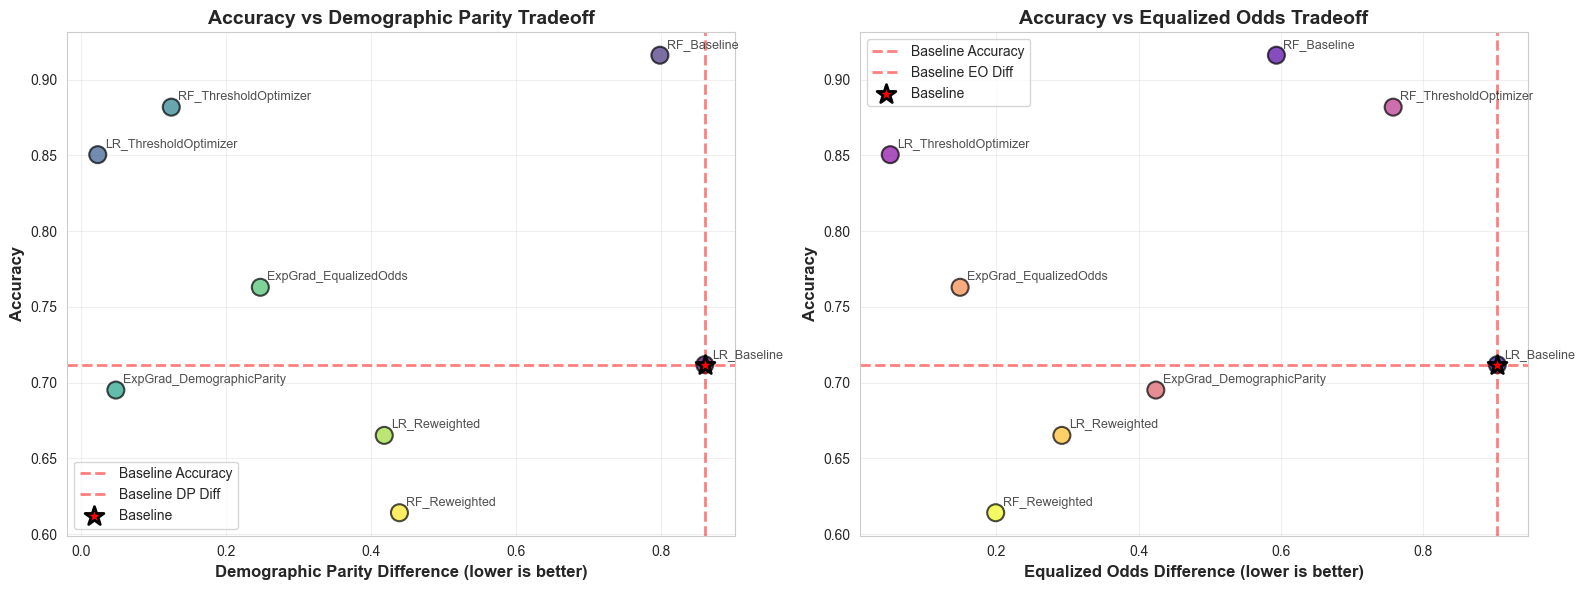

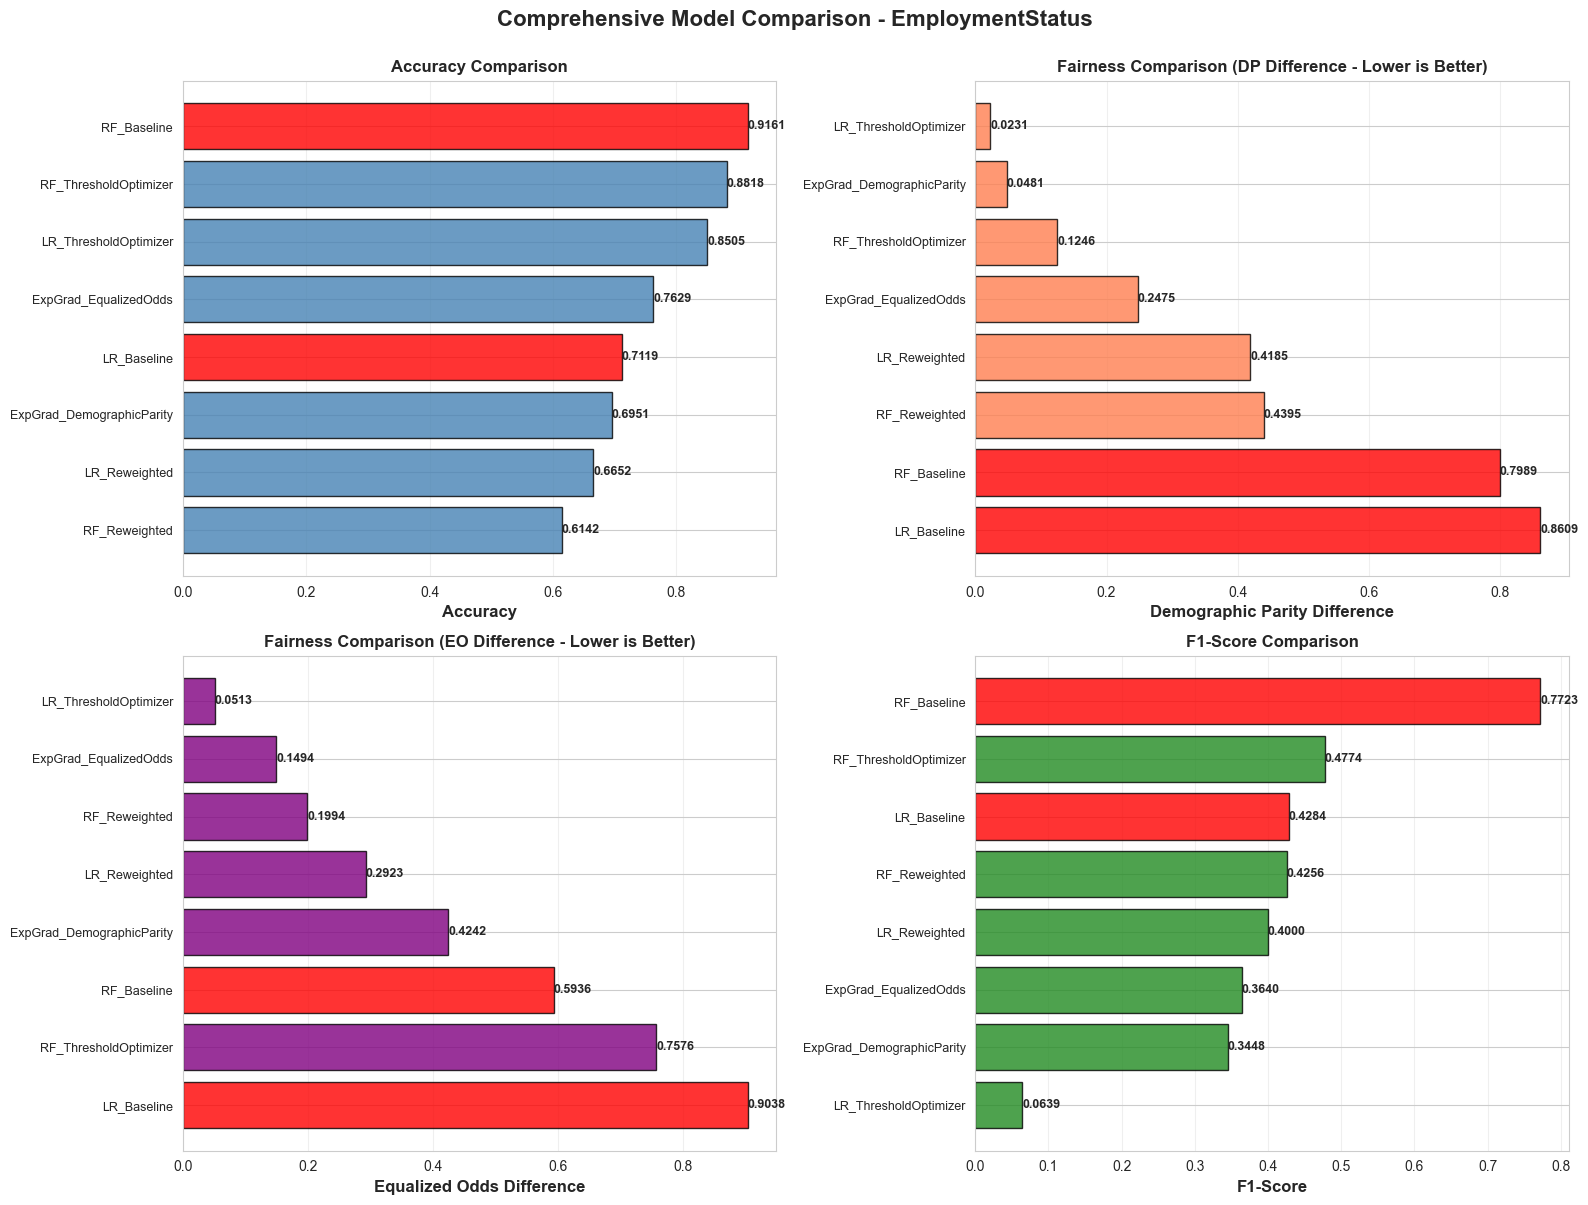

Visualizations complete!


In [10]:
if primary_attr and len(comparison_df) > 0:
    print("=" * 60)
    print("FAIRNESS-ACCURACY TRADEOFF VISUALIZATION")
    print("=" * 60)
    
    # Filter out rows with NaN values for visualization
    comparison_df_clean = comparison_df.dropna(subset=['DP Difference', 'Accuracy', 'EO Difference'])
    
    if len(comparison_df_clean) == 0:
        print("Warning: No valid data points for visualization (all NaN).")
    else:
        # Create tradeoff plots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Accuracy vs Demographic Parity Difference
        ax1 = axes[0]
        
        # Filter valid points for DP plot
        valid_dp = comparison_df_clean.dropna(subset=['DP Difference', 'Accuracy'])
        if len(valid_dp) > 0:
            scatter1 = ax1.scatter(
                valid_dp['DP Difference'],
                valid_dp['Accuracy'],
                s=150,
                alpha=0.7,
                c=range(len(valid_dp)),
                cmap='viridis',
                edgecolors='black',
                linewidths=1.5
            )
            
            # Annotate points
            for idx, row in valid_dp.iterrows():
                if not (pd.isna(row['DP Difference']) or pd.isna(row['Accuracy'])):
                    ax1.annotate(
                        row['Approach'],
                        (row['DP Difference'], row['Accuracy']),
                        fontsize=9,
                        alpha=0.8,
                        xytext=(5, 5),
                        textcoords='offset points'
                    )
        else:
            print("Warning: No valid data points for DP Difference plot")
        
        # Set up axes labels even if no data
        ax1.set_xlabel('Demographic Parity Difference (lower is better)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax1.set_title('Accuracy vs Demographic Parity Tradeoff', fontsize=14, fontweight='bold')
        ax1.grid(alpha=0.3)
        
        # Add reference lines for baseline (if available and valid)
        baseline_mask = comparison_df['Approach'] == 'LR_Baseline'
        if baseline_mask.any():
            baseline_row = comparison_df[baseline_mask].iloc[0]
            if not (pd.isna(baseline_row['Accuracy']) or pd.isna(baseline_row['DP Difference'])):
                ax1.axhline(y=baseline_row['Accuracy'], color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline Accuracy')
                ax1.axvline(x=baseline_row['DP Difference'], color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline DP Diff')
                ax1.scatter([baseline_row['DP Difference']], [baseline_row['Accuracy']], 
                           s=200, color='red', marker='*', edgecolors='black', linewidths=2, 
                           zorder=5, label='Baseline')
        
        ax1.legend(loc='best')
        
        # Plot 2: Accuracy vs Equalized Odds Difference
        ax2 = axes[1]
        valid_eo = comparison_df_clean.dropna(subset=['EO Difference', 'Accuracy'])
        if len(valid_eo) > 0:
            scatter2 = ax2.scatter(
                valid_eo['EO Difference'],
                valid_eo['Accuracy'],
                s=150,
                alpha=0.7,
                c=range(len(valid_eo)),
                cmap='plasma',
                edgecolors='black',
                linewidths=1.5
            )
            
            # Annotate points
            for idx, row in valid_eo.iterrows():
                if not (pd.isna(row['EO Difference']) or pd.isna(row['Accuracy'])):
                    ax2.annotate(
                        row['Approach'],
                        (row['EO Difference'], row['Accuracy']),
                        fontsize=9,
                        alpha=0.8,
                        xytext=(5, 5),
                        textcoords='offset points'
                    )
        else:
            print("Warning: No valid data points for EO Difference plot")
        
        ax2.set_xlabel('Equalized Odds Difference (lower is better)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax2.set_title('Accuracy vs Equalized Odds Tradeoff', fontsize=14, fontweight='bold')
        ax2.grid(alpha=0.3)
        
        # Add reference lines for baseline (if available and valid)
        if baseline_mask.any():
            baseline_row = comparison_df[baseline_mask].iloc[0]
            if not (pd.isna(baseline_row['Accuracy']) or pd.isna(baseline_row['EO Difference'])):
                ax2.axhline(y=baseline_row['Accuracy'], color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline Accuracy')
                ax2.axvline(x=baseline_row['EO Difference'], color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline EO Diff')
                ax2.scatter([baseline_row['EO Difference']], [baseline_row['Accuracy']], 
                           s=200, color='red', marker='*', edgecolors='black', linewidths=2, 
                           zorder=5, label='Baseline')
        
        ax2.legend(loc='best')
        
        plt.tight_layout()
        plt.show()
        
        # Create bar chart comparison
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Comprehensive Model Comparison - {primary_attr}', fontsize=16, fontweight='bold', y=1.00)
        
        # Accuracy comparison
        ax = axes[0, 0]
        comparison_df_sorted = comparison_df.dropna(subset=['Accuracy']).sort_values('Accuracy', ascending=False)
        if len(comparison_df_sorted) > 0:
            colors = ['red' if 'Baseline' in name else 'steelblue' for name in comparison_df_sorted['Approach']]
            ax.barh(range(len(comparison_df_sorted)), comparison_df_sorted['Accuracy'], color=colors, alpha=0.8, edgecolor='black')
            ax.set_yticks(range(len(comparison_df_sorted)))
            ax.set_yticklabels(comparison_df_sorted['Approach'], fontsize=9)
            ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
            ax.set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            for i, v in enumerate(comparison_df_sorted['Accuracy']):
                if not pd.isna(v):
                    ax.text(v, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)
            ax.invert_yaxis()
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
        
        # DP Difference comparison
        ax = axes[0, 1]
        comparison_df_sorted_dp = comparison_df.dropna(subset=['DP Difference']).sort_values('DP Difference', ascending=True)
        if len(comparison_df_sorted_dp) > 0:
            colors = ['red' if 'Baseline' in name else 'coral' for name in comparison_df_sorted_dp['Approach']]
            ax.barh(range(len(comparison_df_sorted_dp)), comparison_df_sorted_dp['DP Difference'], color=colors, alpha=0.8, edgecolor='black')
            ax.set_yticks(range(len(comparison_df_sorted_dp)))
            ax.set_yticklabels(comparison_df_sorted_dp['Approach'], fontsize=9)
            ax.set_xlabel('Demographic Parity Difference', fontsize=12, fontweight='bold')
            ax.set_title('Fairness Comparison (DP Difference - Lower is Better)', fontsize=12, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            for i, v in enumerate(comparison_df_sorted_dp['DP Difference']):
                if not pd.isna(v):
                    ax.text(v, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)
            ax.invert_yaxis()
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Fairness Comparison (DP Difference - Lower is Better)', fontsize=12, fontweight='bold')
        
        # EO Difference comparison
        ax = axes[1, 0]
        comparison_df_sorted_eo = comparison_df.dropna(subset=['EO Difference']).sort_values('EO Difference', ascending=True)
        if len(comparison_df_sorted_eo) > 0:
            colors = ['red' if 'Baseline' in name else 'purple' for name in comparison_df_sorted_eo['Approach']]
            ax.barh(range(len(comparison_df_sorted_eo)), comparison_df_sorted_eo['EO Difference'], color=colors, alpha=0.8, edgecolor='black')
            ax.set_yticks(range(len(comparison_df_sorted_eo)))
            ax.set_yticklabels(comparison_df_sorted_eo['Approach'], fontsize=9)
            ax.set_xlabel('Equalized Odds Difference', fontsize=12, fontweight='bold')
            ax.set_title('Fairness Comparison (EO Difference - Lower is Better)', fontsize=12, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            for i, v in enumerate(comparison_df_sorted_eo['EO Difference']):
                if not pd.isna(v):
                    ax.text(v, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)
            ax.invert_yaxis()
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Fairness Comparison (EO Difference - Lower is Better)', fontsize=12, fontweight='bold')
        
        # F1-Score comparison
        ax = axes[1, 1]
        comparison_df_sorted_f1 = comparison_df.dropna(subset=['F1-Score']).sort_values('F1-Score', ascending=False)
        if len(comparison_df_sorted_f1) > 0:
            colors = ['red' if 'Baseline' in name else 'forestgreen' for name in comparison_df_sorted_f1['Approach']]
            ax.barh(range(len(comparison_df_sorted_f1)), comparison_df_sorted_f1['F1-Score'], color=colors, alpha=0.8, edgecolor='black')
            ax.set_yticks(range(len(comparison_df_sorted_f1)))
            ax.set_yticklabels(comparison_df_sorted_f1['Approach'], fontsize=9)
            ax.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
            ax.set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            for i, v in enumerate(comparison_df_sorted_f1['F1-Score']):
                if not pd.isna(v):
                    ax.text(v, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)
            ax.invert_yaxis()
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("Visualizations complete!")
else:
    print("Warning: Cannot create visualizations without comparison data.")


## 8. Save Mitigated Models and Results

Save all mitigated models, predictions, and comparison results for final analysis in notebook 05.


In [11]:
print("=" * 60)
print("SAVING MITIGATED MODELS AND RESULTS")
print("=" * 60)

# Ensure results directory exists
results_dir.mkdir(exist_ok=True)

# Save mitigated models
print("\nSaving mitigated models...")
models_saved = 0
for model_name, model_obj in mitigated_models.items():
    try:
        filename = f"{model_name.lower().replace(' ', '_').replace('-', '_')}_model.pkl"
        filepath = results_dir / filename
        with open(filepath, 'wb') as f:
            pickle.dump(model_obj, f)
        print(f"  Saved: {filename}")
        models_saved += 1
    except Exception as e:
        print(f"  Warning: Could not save {model_name}: {type(e).__name__}")

print(f"\nSaved {models_saved} mitigated model(s)")

# Prepare results for JSON serialization
def safe_convert(value):
    """Convert value to JSON-serializable format."""
    if pd.isna(value) or (isinstance(value, float) and np.isnan(value)):
        return None
    try:
        return float(value)
    except (TypeError, ValueError):
        return str(value)

# Save mitigation results
print("\nSaving mitigation results...")
mitigation_results_serializable = {}
for approach_name, attr_results in mitigation_results.items():
    mitigation_results_serializable[approach_name] = {}
    for attr_name, metrics in attr_results.items():
        mitigation_results_serializable[approach_name][attr_name] = {
            k: safe_convert(v) for k, v in metrics.items()
        }

with open(results_dir / 'mitigation_results.json', 'w') as f:
    json.dump(mitigation_results_serializable, f, indent=2)
print("  Saved: mitigation_results.json")

# Save comparison table
if len(comparison_df) > 0:
    comparison_df.to_csv(results_dir / 'mitigation_comparison.csv', index=False)
    print("  Saved: mitigation_comparison.csv")

# Save comprehensive comparison including baselines
all_results_serializable = {}
for approach_name, attr_results in all_results.items():
    all_results_serializable[approach_name] = {}
    for attr_name, metrics in attr_results.items():
        all_results_serializable[approach_name][attr_name] = {
            k: safe_convert(v) for k, v in metrics.items()
        }

with open(results_dir / 'all_models_comparison.json', 'w') as f:
    json.dump(all_results_serializable, f, indent=2)
print("  Saved: all_models_comparison.json")

print(f"\nAll files saved to: {results_dir.absolute()}")

print("\nSaved files:")
print("  Models:")
for model_name in mitigated_models.keys():
    filename = f"{model_name.lower().replace(' ', '_').replace('-', '_')}_model.pkl"
    print(f"    - {filename}")
print("  Results:")
print("    - mitigation_results.json")
if len(comparison_df) > 0:
    print("    - mitigation_comparison.csv")
print("    - all_models_comparison.json")

print("\n" + "=" * 60)
print("NOTEBOOK COMPLETE!")
print("=" * 60)
print("Next steps:")
print("  Proceed to notebook 05_comparison.ipynb")
print("  Load comparison results and create final analysis")
print("  Generate final report with recommendations")


SAVING MITIGATED MODELS AND RESULTS

Saving mitigated models...
  Saved: lr_thresholdoptimizer_model.pkl
  Saved: rf_thresholdoptimizer_model.pkl
  Saved: expgrad_demographicparity_model.pkl
  Saved: expgrad_equalizedodds_model.pkl
  Saved: lr_reweighted_model.pkl
  Saved: rf_reweighted_model.pkl

Saved 6 mitigated model(s)

Saving mitigation results...
  Saved: mitigation_results.json
  Saved: mitigation_comparison.csv
  Saved: all_models_comparison.json

All files saved to: c:\Users\Anthony Stills Jr\Documents\CS Projects\insurance-fairness\notebooks\..\results

Saved files:
  Models:
    - lr_thresholdoptimizer_model.pkl
    - rf_thresholdoptimizer_model.pkl
    - expgrad_demographicparity_model.pkl
    - expgrad_equalizedodds_model.pkl
    - lr_reweighted_model.pkl
    - rf_reweighted_model.pkl
  Results:
    - mitigation_results.json
    - mitigation_comparison.csv
    - all_models_comparison.json

NOTEBOOK COMPLETE!
Next steps:
  Proceed to notebook 05_comparison.ipynb
  Load com